In [177]:
import torch
import torchvision
import torchvision.transforms as transforms # common image transformations that can be chained together using Compose
import torch.nn as nn
import torch.nn.functional as F
import math

In [178]:
# set up MPS
device = 'cpu'

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")
    print("MPS is available!")

MPS is available!


In [179]:
# create a transform object that converts an image to a tensor and normalizes its pixel values
transform = transforms.Compose(
    [transforms.ToTensor(), # convert image to tensor
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize pixel values of image

In [180]:
batch_size = 4 # number of images per batch

# download training dataset, apply transform, and load into DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, # load data in batches
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, # download test dataset
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, # load data in batches
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', # class labels
            'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [139]:
# show some of the training images
import matplotlib.pyplot as plt
import numpy as np

In [140]:
def showimg(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy array
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose to get correct image orientation
  plt.show()

In [141]:
# get some random training images
dataiter = iter(trainloader) # create an iterator
images, labels = next(dataiter) # get the next batch of images and labels

# # show images
# showimg(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [181]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()  # call the __init__() method of the parent class
        # define the layers of the network here
        self.conv1 = nn.Conv2d(
            3, 6, 5
        )  # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2
        self.conv2 = nn.Conv2d(
            6, 16, 5
        )  # 6 input channels, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(
            16 * 5 * 5, 120
        )  # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 120)  # 120 input features, 84 output features
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)  # 84 input features, 10 output features

    def forward(self, x):  # define the forward pass
        x = self.pool(F.relu(self.conv1(x)))  # convolve, apply ReLU, then pool
        x = self.pool(F.relu(self.conv2(x)))  # convolve, apply ReLU, then pool
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))  # apply ReLU
        x = F.relu(self.fc2(x))  # apply ReLU
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # output layer
        return x

In [183]:
def print_params(model: nn.Module):
  """
  Print the number of trainable and untrainable parameters in the model.
  
  Args:
    model: The model to print the parameters of.
  """
  print("Layers:")
  for name, param in net.named_parameters():
    print(f"- {name} of size {param.size()} -> {'trainable' if param.requires_grad else 'untrainable'}")

  trainable = 0 # number of trainable parameters
  untrainable = 0 # number of untrainable parameters
  for name, param in model.named_parameters(): # iterate over the parameters of the model
    if param.requires_grad: # if the parameter requires a gradient
      trainable += param.numel() # increment the number of trainable parameters
    else: # otherwise
      untrainable += param.numel() # increment the number of untrainable parameters
  print(f"\nTrainable parameters: {trainable}")
  print(f"Untrainable parameters: {untrainable}")
  print(f"Total parameters: {trainable + untrainable}")
  print(f"Percent trainable: {100 * trainable / (trainable + untrainable)}%")

In [184]:
net = ConvNet() # create a ConvNet object
print_params(net) # print the number of trainable and untrainable parameters in the model

Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> trainable
- conv1.bias of size torch.Size([6]) -> trainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> trainable
- conv2.bias of size torch.Size([16]) -> trainable
- fc1.weight of size torch.Size([120, 400]) -> trainable
- fc1.bias of size torch.Size([120]) -> trainable
- fc2.weight of size torch.Size([120, 120]) -> trainable
- fc2.bias of size torch.Size([120]) -> trainable
- fc3.weight of size torch.Size([84, 120]) -> trainable
- fc3.bias of size torch.Size([84]) -> trainable
- fc4.weight of size torch.Size([10, 84]) -> trainable
- fc4.bias of size torch.Size([10]) -> trainable

Trainable parameters: 76526
Untrainable parameters: 0
Total parameters: 76526
Percent trainable: 100.0%


In [185]:
import torch.optim as optim # package with common optimization algorithms

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # optimizer

In [186]:
def train(model, criterion, optimizer, trainloader, num_epochs=2):
    model.to(device)  # move the model to the device

    for epoch in range(num_epochs):
        running_loss = 0.0  # keep track of running loss
        for i, data in enumerate(trainloader, 0):  # iterate over data
            inputs, labels = data[0].to(device), data[1].to(device)  # get inputs and labels

            # zero the parameter gradients (otherwise they are accumulated)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # compute loss
            loss.backward()  # backward pass
            optimizer.step()  # optimize

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0
        print('Finished epoch %d' % (epoch + 1))

    print('Finished training')

In [187]:
train(net, criterion, optimizer, trainloader, num_epochs=2)

[1,  2000] loss: 2.301
[1,  4000] loss: 2.126
[1,  6000] loss: 1.830
[1,  8000] loss: 1.710
[1, 10000] loss: 1.600
[1, 12000] loss: 1.527
Finished epoch 1
[2,  2000] loss: 1.436
[2,  4000] loss: 1.418
[2,  6000] loss: 1.362
[2,  8000] loss: 1.319
[2, 10000] loss: 1.323
[2, 12000] loss: 1.289
Finished epoch 2
Finished training


In [188]:
PATH = './cifar_net.pth' # path to save the model
torch.save(net.state_dict(), PATH) # save the model

In [189]:
def test_model(model, testloader, classes):
    """
    Test the model and print out the total accuracy and the accuracy for each class.
    
    Args:
        model: The model to test.
        testloader: The DataLoader for the test data.
        classes: The class labels.
    """
    dataiter = iter(testloader) # create an iterator
    images, labels = next(dataiter) # get the next batch of images and labels

    # print images
    showimg(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

    images = images.to(device)
    outputs = net(images) # get the network's predictions

    _, predicted = torch.max(outputs, 1) # get the class with the highest score
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                for j in range(batch_size)))


    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    with torch.no_grad(): # don't compute gradients
        for data in testloader: # iterate over data
            images, labels = data[0].to(device), data[1].to(device) # get inputs and labels
            outputs = model(images) # get the network's predictions
            _, predicted = torch.max(outputs.data, 1) # get the class with the highest score
            total += labels.size(0) # increment total by the number of labels
            correct += (predicted == labels).sum().item() # increment correct by the number of correct predictions

            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%\n")

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

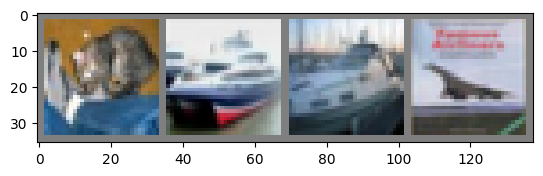

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane
Accuracy of the network on the 10000 test images: 55.1%

Accuracy of plane : 75 %
Accuracy of   car : 75 %
Accuracy of  bird : 35 %
Accuracy of   cat : 37 %
Accuracy of  deer : 51 %
Accuracy of   dog : 40 %
Accuracy of  frog : 62 %
Accuracy of horse : 56 %
Accuracy of  ship : 62 %
Accuracy of truck : 53 %


In [190]:
test_model(net, testloader, classes)

In [191]:
# let's start building out a LoRALinear layer
class LoRALinear(nn.Module):
  """
  This is a low-rank adapted linear layer that can be used to replace a standard linear layer.
  
  
  Args:
    module: The linear layer module to adapt.
    rank: The rank of the approximation.
    alpha: The alpha parameter.
  """

  def __init__(
    self,
    module: nn.Module,
    # in_dim: int,
    # out_dim: int,
    rank: int = 4,
    alpha: float = 4.0
  ):
    # ensure the module is a linear layer
    assert isinstance(module, nn.Linear), "Module must be a linear layer."

    super().__init__() # call the __init__() method of the parent class
    self.rank = rank # rank of the approximation
    self.alpha = alpha # alpha parameter
    self.scaling = self.alpha / self.rank # scaling factor
    self.in_dim = module.in_features # number of input features
    self.out_dim = module.out_features # number of output features

    # make sure that rank is at least 1
    assert self.rank >= 1, "Rank must be at least 1."

    # recreate the linear layer and freeze it
    # note: we will copy over the pretrained weights after initializing
    self.pretrained = nn.Linear(self.in_dim, self.out_dim, bias=True)
    self.pretrained.weight = nn.Parameter(module.weight.detach().clone())
    self.pretrained.bias = nn.Parameter(module.bias.detach().clone())
    self.pretrained.weight.requires_grad = False # freeze the weights
    self.pretrained.bias.requires_grad = False # freeze the bias

    # create the A and initialize with Kaiming
    self.A = nn.Linear(self.in_dim, rank, bias=False)
    nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))

    # create B and initialize with zeros
    self.B = nn.Linear(rank, self.out_dim, bias=False)
    nn.init.zeros_(self.B.weight)

    # ensure that the weights in A and B are trainable
    self.A.weight.requires_grad = True
    self.B.weight.requires_grad = True

  def forward(self, x: torch.Tensor):
    """
    Perform the forward pass of the layer.
    
    Args:
      x: The input tensor.
    """
    pretrained_out = self.pretrained(x) # get the pretrained weights
    lora_out = self.A(x) # 
    lora_out = self.B(lora_out)
    lora_out = lora_out * self.scaling
    return pretrained_out + lora_out
  





In [192]:
def freeze_parameters(model: nn.Module):
  """
  Freeze all parameters in the model.
  
  Args:
    model: The model to freeze the parameters of.
  """
  for param in model.parameters(): # iterate over the parameters of the model
    param.requires_grad = False # freeze the parameter

def unfreeze_parameters(model: nn.Module):
  """
  Unfreeze all parameters in the model.
  
  Args:
    model: The model to unfreeze the parameters of.
  """
  for param in model.parameters(): # iterate over the parameters of the model
    param.requires_grad = True # unfreeze the parameter

# create a function to replace all linear layers in the the net with LoRALinear layers
def update_model(model: nn.Module, rank: int = 4, alpha: float = 4.0, device: str = 'cpu'):
  """
  Replaces all linear layers in the model with LoRALinear layers.
  
  Args:
    model: The model to update.
    rank: The rank of the approximation.
    alpha: The alpha parameter.
  """
  freeze_parameters(model) # freeze all parameters in the model

  for name, module in model.named_children(): # iterate over the children of the model
    if isinstance(module, nn.Linear): # if the module is a linear layer
      setattr(model, name, LoRALinear(module, rank, alpha)) # replace it with a LoRALinear layer
      print(f"Replaced {name} with LoRALinear layer.")
    else: # otherwise
      update_model(module, rank, alpha) # recursively call the function on the module

  # move the model to the device
  model.to(device)

  # ensure low-rank matrices are trainable
  for name, module in model.named_modules():
    if isinstance(module, LoRALinear):
      module.A.weight.requires_grad = True
      module.B.weight.requires_grad = True

In [193]:
freeze_parameters(net)
print_params(net)
unfreeze_parameters(net)
print_params(net)

Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([6]) -> untrainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([16]) -> untrainable
- fc1.weight of size torch.Size([120, 400]) -> untrainable
- fc1.bias of size torch.Size([120]) -> untrainable
- fc2.weight of size torch.Size([120, 120]) -> untrainable
- fc2.bias of size torch.Size([120]) -> untrainable
- fc3.weight of size torch.Size([84, 120]) -> untrainable
- fc3.bias of size torch.Size([84]) -> untrainable
- fc4.weight of size torch.Size([10, 84]) -> untrainable
- fc4.bias of size torch.Size([10]) -> untrainable

Trainable parameters: 0
Untrainable parameters: 76526
Total parameters: 76526
Percent trainable: 0.0%
Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> trainable
- conv1.bias of size torch.Size([6]) -> trainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> trainable
- conv2.bias of size torch.Size([16])

In [194]:
update_model(net, device=device) # update the model
print_params(net) # print the number of parameters

Replaced fc1 with LoRALinear layer.
Replaced fc2 with LoRALinear layer.
Replaced fc3 with LoRALinear layer.
Replaced fc4 with LoRALinear layer.
Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([6]) -> untrainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([16]) -> untrainable
- fc1.pretrained.weight of size torch.Size([120, 400]) -> untrainable
- fc1.pretrained.bias of size torch.Size([120]) -> untrainable
- fc1.A.weight of size torch.Size([4, 400]) -> trainable
- fc1.B.weight of size torch.Size([120, 4]) -> trainable
- fc2.pretrained.weight of size torch.Size([120, 120]) -> untrainable
- fc2.pretrained.bias of size torch.Size([120]) -> untrainable
- fc2.A.weight of size torch.Size([4, 120]) -> trainable
- fc2.B.weight of size torch.Size([120, 4]) -> trainable
- fc3.pretrained.weight of size torch.Size([84, 120]) -> untrainable
- fc3.pretrained.bias of size torch.Size([84]) -> unt

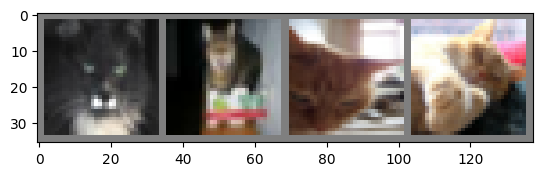

In [195]:
# it looks like class 'cat' had the lowest accuracy; let's fine tune the lora adapted
# model on only the cat class

# create a trainloader for only the cat class
cat_trainset = [data for data in trainset if data[1] == classes.index('cat')]
cat_trainloader = torch.utils.data.DataLoader(cat_trainset, batch_size=4, shuffle=True, num_workers=2)

# let's print a few of the cat images# Display some of the cat images
cat_dataiter = iter(cat_trainloader) # create an iterator
cat_images, cat_labels = next(dataiter) # get the next batch of images and labels

# print images
showimg(torchvision.utils.make_grid(cat_images))


In [199]:
# let's continue training the lora-adapted model on just the cat class
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # update the optimizer for the new parameters
train(net, criterion, optimizer, cat_trainloader, num_epochs=3)


Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished training


In [200]:
# double check the params
print_params(net)

# some of the A and B matrices should have changed
# check to see if B weights are non-zero
for name, param in net.named_parameters():
  if 'B.weight' in name:
    print(f"{name} has all zero weights: {torch.all(param == 0)}")

Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([6]) -> untrainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([16]) -> untrainable
- fc1.pretrained.weight of size torch.Size([120, 400]) -> untrainable
- fc1.pretrained.bias of size torch.Size([120]) -> untrainable
- fc1.A.weight of size torch.Size([4, 400]) -> trainable
- fc1.B.weight of size torch.Size([120, 4]) -> trainable
- fc2.pretrained.weight of size torch.Size([120, 120]) -> untrainable
- fc2.pretrained.bias of size torch.Size([120]) -> untrainable
- fc2.A.weight of size torch.Size([4, 120]) -> trainable
- fc2.B.weight of size torch.Size([120, 4]) -> trainable
- fc3.pretrained.weight of size torch.Size([84, 120]) -> untrainable
- fc3.pretrained.bias of size torch.Size([84]) -> untrainable
- fc3.A.weight of size torch.Size([4, 120]) -> trainable
- fc3.B.weight of size torch.Size([84, 4]) -> trainable
- fc4.pretrained.weigh

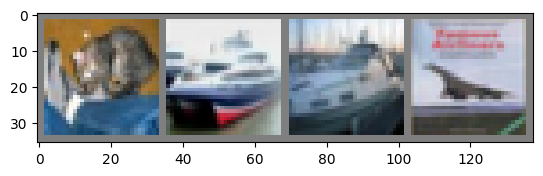

GroundTruth:    cat  ship  ship plane
Predicted:    cat   cat   cat   cat
Accuracy of the network on the 10000 test images: 11.0%

Accuracy of plane :  3 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat : 100 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  5 %
Accuracy of truck :  0 %


In [201]:
# let's check the accuracy on all classes again
test_model(net, testloader, classes)